# Home Price Prediction

Predicting home prices based on square footage, units, floors, year, month, quarter, and day of week of sale.

## Imports and helper functions

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, MinMaxScaler, MaxAbsScaler, RobustScaler
from sklearn.model_selection import train_test_split, RepeatedKFold

from sklearn.tree import ExtraTreeRegressor
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import RepeatedKFold, cross_validate
from sklearn.tree import ExtraTreeRegressor, DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge
from lightgbm import LGBMRegressor

In [53]:
# simple function to generate random integers

def rand_gen(low=1,high=1e4):
    '''
    Generates a pseudo-random integer
    consisting of up to four digits
    '''
    import numpy as np
    rng=np.random.default_rng()
    random_state=int(rng.integers(low=low,high=high))
    
    return random_state

seed=rand_gen()
seed

# save random seed for project
with open('seed.txt', 'w') as file:
    file.write(str(seed))

# set the randomness seed throughout the notebook
# source: # https://odsc.medium.com/properly-setting-the-random-seed-in-ml-experiments-not-as-simple-as-you-might-imagine-219969c84752

## set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed)
## set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed)
## set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed)
np.random.default_rng(seed)

seed

3630

In [54]:
import json
from pathlib import Path
import inspect
from datetime import datetime

def get_variable_name(var):
    callers_local_vars = inspect.currentframe().f_back.f_locals.items()
    return [name for name, val in callers_local_vars if val is var]

def fileDaterSaver(location: str,
                   filetype: str,
                   object_,
                   extra: str = '',
                   verbose: bool = True):

    '''
    Function that gets a timestamped filename and saves it
    to a user-specified location.

    Parameters:
    -----------
    location: str - The location where the file will be saved.
    filetype: str - The type of the file to save ('csv' or 'json').
    object_: The object to be saved. Should be a pandas DataFrame
        for 'csv' or serializable for 'json'.
    extra: str - Additional string to include in the filename.
    verbose: bool - Whether to print verbose messages.
    '''

    # get current date and time
    current_datetime = datetime.now()

    # print current date and time to check
    if verbose:
        print('current_datetime:', current_datetime)

    # format the datetime for a filename
    datetime_suffix = current_datetime.strftime("%Y-%m-%d_%H-%M-%S")

    # create filename with the datetime suffix
    if extra != '':
        file_name = f'{location}{extra}_{datetime_suffix}.{filetype}'
    else:
        file_name = f'{location}{datetime_suffix}.{filetype}'

    # print file name
    if verbose:
        print(file_name)

    # save object
    if filetype == 'csv':
        object_.to_csv(file_name, index=True)
    elif filetype == 'json':
        with open(file_name, 'w') as file:
            file.write(json.dumps(object_, default=str))
    else:
        raise ValueError("Unsupported file type. Use 'csv' or 'json'.")

    # confirm save
    file_path = Path(file_name)
    if file_path.exists():
        variable_name = get_variable_name(object_)
        if variable_name:
            print(f'Successfully saved {variable_name[0]} to {file_path}')
        else:
            print(f'Successfully saved object to {file_path}')
    else:
        print("File save error.")

In [55]:
# read in the data
df = pd.read_csv('../data/df_lownull_clean.csv', parse_dates=True)

df['date'] = df['date'].astype('datetime64[ns]')
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day_of_week'] = df['date'].dt.day_of_week
df['quarter'] = df['date'].dt.quarter
df = df.drop(columns=['Unnamed: 0'])

df.head()

,date,sale_ask,units,floors,sf,annual$,year,month,day_of_week,quarter,ppsf
0,2010-01-03,770000.0,1.0,2.5,2722.0,36033.0,2010,1,6,1,282.880235
1,2010-01-06,1397478.0,2.0,3.0,3780.0,63202.0,2010,1,2,1,369.703175
2,2010-01-10,505000.0,1.0,1.0,800.0,30089.0,2010,1,6,1,631.250000
3,2010-01-11,450000.0,1.0,1.0,650.0,31473.0,2010,1,0,1,692.307692
4,2010-01-11,1530000.0,3.0,3.0,3200.0,69400.0,2010,1,0,1,478.125000


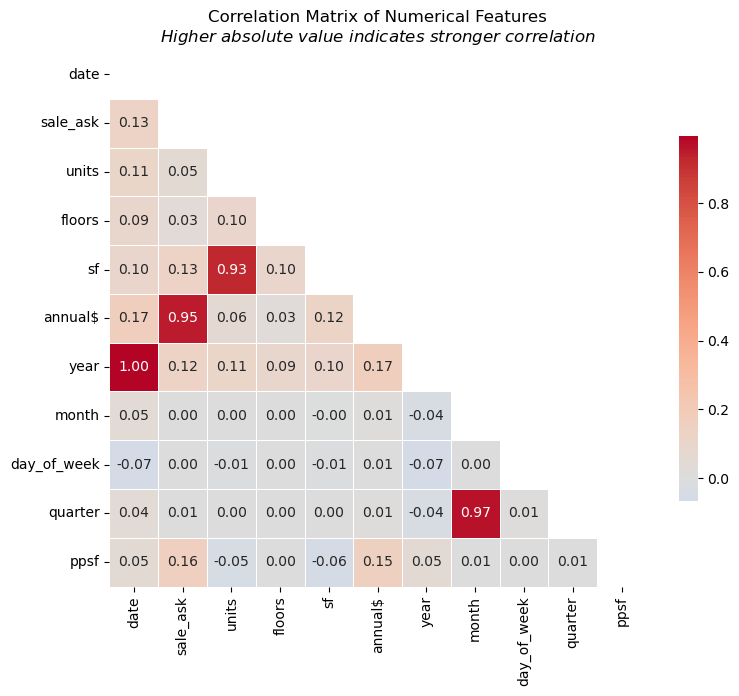

In [56]:
# compute correlation matrix
corr=df.corr()

# generate mask for the upper triangle
mask=np.triu(np.ones_like(corr, dtype=bool))

# set up matplotlib figure
f,ax = plt.subplots(figsize=(8, 8))

# draw heatmap with the mask and correct aspect ratio
sns.heatmap(corr,mask=mask,cmap='coolwarm',#vmax=1,vmin=-1,
            center=0,
            square=True,linewidths=.5,annot=True,
            fmt='.2f',cbar_kws={"shrink":.5})
plt.title('Correlation Matrix of Numerical Features\n$Higher$ $absolute$ $value$ $indicates$ $stronger$ $correlation$')
plt.tight_layout()

# save fig
plt.savefig('../figs/corrmatrix.pdf')
plt.savefig('../figs/corrmatrix.png')

## Run grid search to experiment on modeling techniques

Given the correlation between date, year, annual$, sf, and units, we will drop the following columns for our analysis:
* `annual$`
* `quarter`
* `units`

In [57]:
# define the dataset
target_column_name = 'sale_ask'
data = df[[col for col in df.columns if col not in ['date', 'annual$', 'quarter', 'units']]]

In [58]:
regressor_map = {
    'etr': ExtraTreeRegressor(random_state=seed),
    'dtr': DecisionTreeRegressor(random_state=seed),
    'rfr': RandomForestRegressor(random_state=seed),
    'lgb': LGBMRegressor(random_state=seed, verbose=-1),
    'lr': LinearRegression(),
    'sgd': SGDRegressor(random_state=seed),
    'ridge': Ridge(random_state=seed),
}

scaling_techniques = [
    StandardScaler(),
    MinMaxScaler(),
    MaxAbsScaler(),
    RobustScaler(),
    None
]

X = data.drop(columns=[target_column_name])
y = data[target_column_name]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=seed
)

X_train_encoded = pd.get_dummies(X_train)
X_test_encoded = pd.get_dummies(X_test).reindex(columns=X_train_encoded.columns, fill_value=0)

# Regression scoring metrics
scoring = {
    'r2': 'r2',
    'neg_mean_squared_error': 'neg_mean_squared_error'
}

all_results = {}

# Cross-validation setup
n_splits = 5
n_repeats = 3
cv = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=seed)

# Define weights for the metrics
weights = {
    'r2': 0.5,
    'mae': -0.3,  # minimize MAE, hence negative weight
    'rmse': -0.2  # minimize RMSE, hence negative weight
}

best_combined_score = float('-inf')
best_model_info = None

for scaler in scaling_techniques:
    if scaler:
        scaler_name = scaler.__class__.__name__
        X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_encoded), columns=X_train_encoded.columns)
        X_test_scaled = pd.DataFrame(scaler.transform(X_test_encoded), columns=X_test_encoded.columns)
    else:
        scaler_name = 'None'
        X_train_scaled = X_train_encoded.copy()
        X_test_scaled = X_test_encoded.copy()
    
    all_results[scaler_name] = {}
    print(f'Scaling technique: {scaler_name}')

    # Train and evaluate models with cross-validation
    for model_name, model in regressor_map.items():
        print(f'Running model: {model_name}')

        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)

        # Compute regression metrics
        r2 = r2_score(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mse)

        # Use cross-validation to evaluate metrics
        scores = cross_validate(
            model, X_train_scaled, y_train, 
            cv=cv, scoring=scoring, return_train_score=True
        )

        # Calculate weighted combined score
        combined_score = (
            weights['r2'] * scores['test_r2'].mean() +
            weights['mae'] * mae +
            weights['rmse'] * rmse
        )

        # Store all metrics for each model
        all_results[scaler_name][model_name] = {
            'mean_r2': scores['test_r2'].mean(),
            'std_r2': scores['test_r2'].std(),
            'mean_neg_mse': scores['test_neg_mean_squared_error'].mean(),
            'std_neg_mse': scores['test_neg_mean_squared_error'].std(),
            'r2': r2,
            'mse': mse,
            'mae': mae,
            'rmse': rmse,
            'all_scores': scores,  # Store the full cross-validation output
            'combined_score': combined_score  # Store the combined score
        }

        # Check for best model based on the combined score
        if combined_score > best_combined_score:
            best_combined_score = combined_score
            best_model_info = (scaler_name, model_name)

        print(f"Model: {model_name} | R2: {r2:.4f}, MSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}, "
              f"Mean R2 (CV): {scores['test_r2'].mean():.4f}")

# Print the best model information
if best_model_info:
    print(f"Best model: {best_model_info[1]} using scaler: {best_model_info[0]}")
    print(f"Combined Score: {best_combined_score}")

Scaling technique: StandardScaler
Running model: etr
Model: etr | R2: 0.4220, MSE: 1187964346653.2849, MAE: 78209.2093, RMSE: 1089937.7719, Mean R2 (CV): 0.7785
Running model: dtr
Model: dtr | R2: 0.9188, MSE: 166841610470.1227, MAE: 35143.2383, RMSE: 408462.4958, Mean R2 (CV): 0.8488
Running model: rfr
Model: rfr | R2: 0.9337, MSE: 136194174608.6107, MAE: 17864.5004, RMSE: 369044.9493, Mean R2 (CV): 0.8578
Running model: lgb
Model: lgb | R2: 0.8025, MSE: 405972620397.6877, MAE: 64542.3993, RMSE: 637159.8076, Mean R2 (CV): 0.7921
Running model: lr
Model: lr | R2: 0.0612, MSE: 1929630290712.3643, MAE: 693129.9185, RMSE: 1389111.3313, Mean R2 (CV): -2.8716
Running model: sgd
Model: sgd | R2: -206532814.6456, MSE: 424522172637218406400.0000, MAE: 6111229057.3649, RMSE: 20603935853.0650, Mean R2 (CV): -41224450.7426
Running model: ridge
Model: ridge | R2: 0.0612, MSE: 1929630859749.8757, MAE: 693130.5061, RMSE: 1389111.5361, Mean R2 (CV): -2.8678
Scaling technique: MinMaxScaler
Running mod

### Save and extract best results

In [59]:
fileDaterSaver(
    location='../joblib/',
    filetype='json',
    object_=all_results,
    extra='survey')

current_datetime: 2024-12-23 23:56:05.986809
../joblib/survey_2024-12-23_23-56-05.json
Successfully saved object_ to ../joblib/survey_2024-12-23_23-56-05.json


In [60]:
file_name='../joblib/survey_2024-12-23_23-56-05.json'

# extract best params file
with open(file_name,'r') as file:
    all_results=json.load(file)

We will use a combined approach by weighing the metrics, as we need both accuracy and size of prediction errors, given the monetary nature of the target variable (sale price).

In [61]:
# initialize variables to track the best score and corresponding model/technique
best_combined_score = float('-inf')  # start with a very low value
best_model_info = None

# iterate through all scaling techniques and models
for scaler_name, techniques in all_results.items():
    for model_name, metrics in techniques.items():
        # extract the combined score for the model
        combined_score = metrics['combined_score']

        # check if this combined score is the highest so far
        if combined_score > best_combined_score:
            best_combined_score = combined_score
            best_model_info = (scaler_name, model_name)

# print the best combined score and corresponding technique and model
if best_model_info:
    print(f"Best Combined Score: {best_combined_score:.4f}")
    print(f"Scaler: {best_model_info[0]}")
    print(f"Model: {best_model_info[1]}")

Best Combined Score: -79167.9111
Scaler: StandardScaler
Model: rfr
